Notebook for incorporating ATAC-seq peak files into the model from naive and stem memory T cells.
Train on DNase, test on ATAC T cells.

We don't currently have truth values for these, but we can look for them.


- What TFs are performing well in the model?

Optimal factors are:

"CTCF", "Pol2", "YY1", "Pol2-4H8", "p300", "c-Myc", "TAF1", "Max", "Rad21", "NRSF", "GABP", "CEBPB", "c-Jun", "ZBTB33", "USF2", "USF-1", "Sin3Ak-20", "RFX5", "Nrf1", "Mxi1", "JunD", "CHD2", "ATF3", "c-Fos", "Znf143", "TR4", "SP1", "SMC3", "SIX5", "Pol2(b)", "MafK", "MAZ", "ELF1", "COREST", "TEAD4", "SP2", "NF-YA", "HDAC2", "GTF2F1", "ETS1", "ELK1", "E2F4", "CHD1", "TBLR1", "TAF7", "RBBP5", "MafF", "MEF2A", "E2F6", "Brg1", "Bach1", "BCLAF1", "eGFP-JunD", "eGFP-JunB", "eGFP-GATA2", "eGFP-FOS", "UBF", "TRIM28", "THAP1", "SETDB1", "SAP30", "PHF8", "HDAC1", "GTF2B", "GATA-1", "CBX3"

- Do any of these TFs have T cell significance?
- Can we compare the predictions to Chip-seq data?
Yes, NRF1 is in this list, and the paper below has Chip-seq for Tn cells!

Data
- NRF1 from https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5399889/ in Tn cells
dbGaP Study Accession: phs001187.v1.p1 

TODO:
1. run naive cell data against model for NRF1
Data for this step was processed on s124 machine, using the ENCODE atac-seq pipeline. 2 replicates from the Blazar lab were used for both Tn and Tsm samples. These sample bam files were deduped, filtered, peak called and replicates were combined using IDR.

IDR data is on s124. Tn IDR data is at 
/data/yosef2/OtherResearchGroups/BlazarLab/atac-seq-pipeline/Tn/cromwell-executions/atac/32082334-ee95-4809-b408-5eb56b522e6f/call-idr/shard-0/execution/rep1-rep2.idr0.05.bfilt.narrowPeak.gz

2. compare predictions to Tn NRF1 chip-seq data from link above

# Imports

In [1]:
import collections
 
import pyDNase
import tensorflow as tf
import h5py
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics
import kipoi
import os
import pybedtools
import torch
import h5sparse
import datetime
import logging

from scipy import stats

from pyDNase import GenomicInterval
from scipy.sparse import coo_matrix, vstack

from scipy.fftpack import fft, ifft

import sys

# Define Paths for this user

In [2]:
########################## PATHS ###########################
# path to where dnase bams are stored. Bams need to be sorted and indexed. See bin/download_dnase_encode.sh for
# data processing
_ENCODE_DATA_PREFIX =  "/data/akmorrow/encode_data/"

deepsea_path = "/data/akmorrow/epitome_data/deepsea_train/"
dnase_preprocessed_path = "/data/akmorrow/epitome_data/processed_dnase/"
feature_path = "/home/eecs/akmorrow/epitome/data/feature_name"

_DEEPSEA_GENOME_REGIONS_FILENAME = "/home/eecs/akmorrow/epitome/data/allTFs.pos.bed"

# DNase filepath dictionary
prefix_ =  "/data/akmorrow/encode_data/"

idr_bed_file = "/home/eecs/akmorrow/epitome/data/download_encode/idr_A549_ATAC.unthresholded-peaks.bed"


# get TF logger
log = logging.getLogger('tensorflow')
tf_log = "/home/eecs/akmorrow/epitome/dnase/tensorflow_combination.log"
fh = logging.FileHandler(tf_log)
fh.setLevel(logging.INFO)
log.addHandler(fh)

In [186]:
exec(open("./constants.py").read())
exec(open("./functions.py").read())

# Location of IDR peaks for naive and stem memory T cells

In [145]:
Tn_peaks = "/home/eecs/akmorrow/epitome/data/Tn-rep1-rep2.idr0.05.bfilt.narrowPeak"
Tsm_peaks = "/home/eecs/akmorrow/epitome/data/Tsm-rep1-rep2.idr0.05.bfilt.narrowPeak"
Tn_peak_vector = bedFile2Vector(Tn_peaks, _DEEPSEA_GENOME_REGIONS_FILENAME, duplicate=False)
Tsm_peak_vector = bedFile2Vector(Tsm_peaks, _DEEPSEA_GENOME_REGIONS_FILENAME, duplicate=False)

/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 17 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))
/data/akmorrow/miniconda3/envs/EpitomeEnv/lib/python3.6/site-packages/pybedtools/bedtool.py:3287: UserWarning: Default names for filetype bed are:
['chrom', 'start', 'end', 'name', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts']
but file has 17 fields; you can supply custom names with the `names` kwarg
  % (self.file_type, _names, self.field_count()))


In [187]:
all_data = load_deepsea_data_allpos_file(deepsea_path)

# Load Data

### Load DeepSEA data

In [ ]:
train_data, valid_data, test_data = load_deepsea_data(deepsea_path)


In [25]:
print(valid_data["x"].shape, train_data["x"].shape, test_data["x"].shape)
print(valid_data["y"].shape, train_data["y"].shape, test_data["y"].shape)

(408000, 4, 1000) (4455024, 4, 1000) (455024, 4, 1000)
(919, 408000) (919, 4455024) (919, 455024)


# Choose cell types and assays

In [315]:
matrix, cellmap, assaymap = get_assays_from_feature_file(feature_path='../data/feature_name', eligible_assays = None, eligible_cells = None)

['K562', 'GM12878', 'HepG2', 'HeLa-S3', 'H1-hESC', 'A549', 'HUVEC', 'GM12891', 'MCF-7', 'GM12892', 'HCT-116', 'T-47D', 'SK-N-SH_RA', 'PANC-1', 'NB4', 'NT2-D1', 'NHEK', 'SK-N-MC', 'ProgFib', 'NHLF', 'NHDF-Ad', 'NH-A', 'HSMMtube', 'HSMM', 'HMEC', 'Gliobla'] ['DNase', 'CTCF', 'Pol2', 'EZH2', 'YY1', 'Pol2-4H8', 'p300', 'c-Myc', 'TAF1', 'Max', 'Rad21', 'NRSF', 'GABP', 'CEBPB', 'c-Jun', 'ZNF274', 'ZBTB33', 'USF2', 'USF-1', 'TCF7L2', 'TBP', 'Sin3Ak-20', 'RFX5', 'Pol2(phosphoS2)', 'Nrf1', 'Mxi1', 'JunD', 'CHD2', 'ATF3', 'c-Fos', 'Znf143', 'TR4', 'TCF12', 'SRF', 'SP1', 'SMC3', 'SIX5', 'Pol2(b)', 'MafK', 'MAZ', 'ELF1', 'COREST', 'BRCA1', 'BHLHE40', 'TEAD4', 'STAT1', 'SP2', 'RXRA', 'PU.1', 'PAX5-C20', 'NFKB', 'NF-YB', 'NF-YA', 'HDAC2', 'GTF2F1', 'FOXA1', 'Egr-1', 'ETS1', 'ELK1', 'E2F4', 'CHD1', 'BCL3', 'ZZZ3', 'ZBTB7A', 'TFIIIC-110', 'TBLR1', 'TAF7', 'SUZ12', 'STAT5A', 'STAT3', 'SIN3A', 'RPC155', 'RBBP5', 'Pol3', 'POU2F2', 'PML', 'NFIC', 'NF-E2', 'MafF', 'MEF2A', 'Ini1', 'IRF3', 'HA-E2F1', 'GATA3

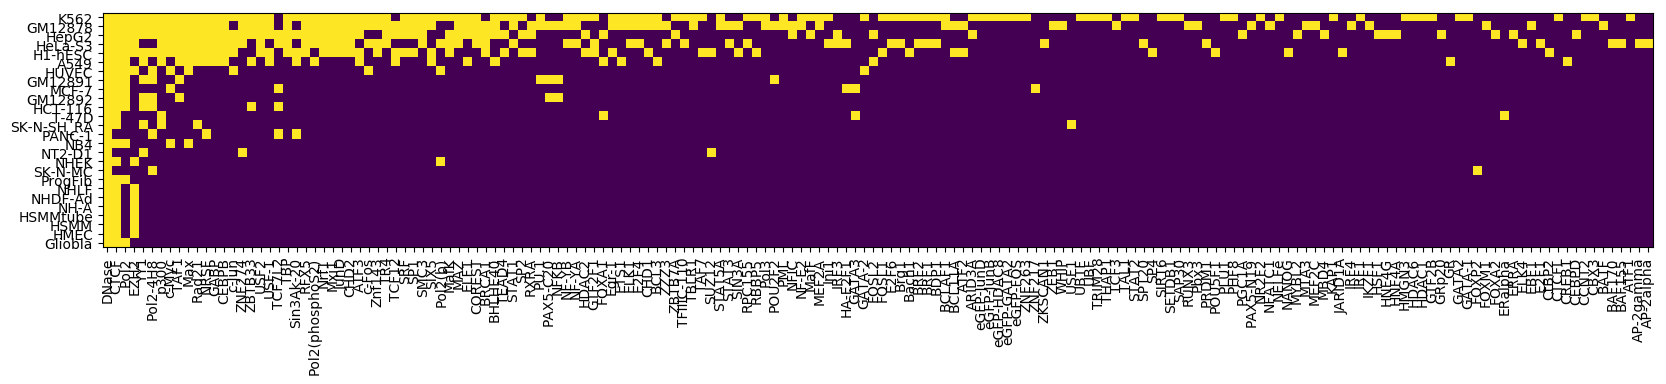

In [316]:
fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)
print(list(cellmap.keys()), list(assaymap.keys()))

In [132]:
matrix, cellmap, assaymap = get_assays_from_feature_file(feature_path='../data/feature_name', eligible_assays = OPTIMAL_ASSAYS, eligible_cells = None)

['K562', 'GM12878', 'HepG2', 'H1-hESC', 'HeLa-S3', 'A549', 'HUVEC', 'HCT-116', 'GM12892', 'GM12891', 'SK-N-SH_RA', 'NB4', 'PANC-1', 'MCF-7', 'T-47D', 'ProgFib', 'NHEK', 'Gliobla'] ['DNase', 'CTCF', 'Pol2', 'YY1', 'Pol2-4H8', 'p300', 'c-Myc', 'TAF1', 'Max', 'Rad21', 'NRSF', 'GABP', 'CEBPB', 'c-Jun', 'ZBTB33', 'USF2', 'USF-1', 'Sin3Ak-20', 'RFX5', 'Nrf1', 'Mxi1', 'JunD', 'CHD2', 'ATF3', 'c-Fos', 'Znf143', 'TR4', 'SP1', 'SMC3', 'SIX5', 'Pol2(b)', 'MafK', 'MAZ', 'ELF1', 'COREST', 'TEAD4', 'SP2', 'NF-YA', 'HDAC2', 'GTF2F1', 'ETS1', 'ELK1', 'E2F4', 'CHD1', 'TBLR1', 'TAF7', 'RBBP5', 'MafF', 'MEF2A', 'E2F6', 'Brg1', 'Bach1', 'BCLAF1', 'eGFP-JunD', 'eGFP-JunB', 'eGFP-GATA2', 'eGFP-FOS', 'UBF', 'TRIM28', 'THAP1', 'SETDB1', 'SAP30', 'PHF8', 'HDAC1', 'GTF2B', 'GATA-1', 'CBX3']


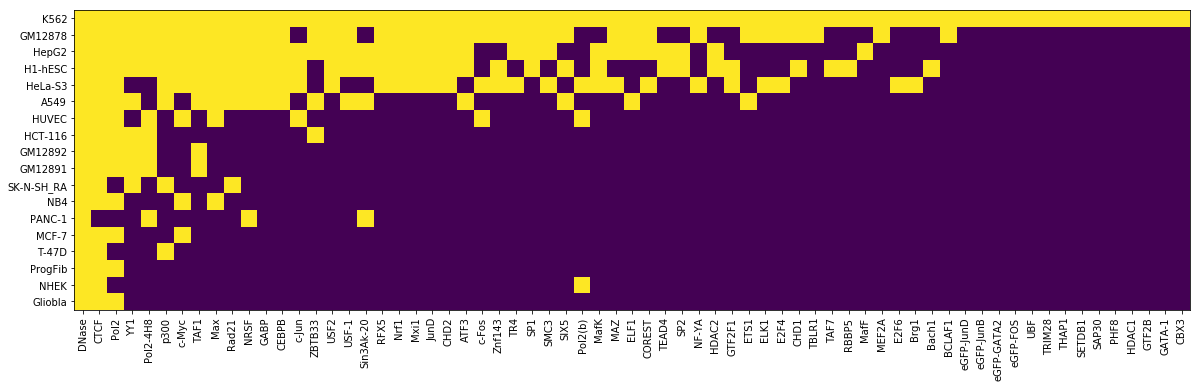

In [134]:
# matrix is cell types by factors, contains indices in feature vector

inv_assaymap = {v: k for k, v in assaymap.items()}

fig = plt.figure(figsize = (20,10))
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.xticks(np.arange(len(assaymap)), rotation = 90)
ax.set_xticklabels(assaymap.keys())
plt.yticks(np.arange(len(cellmap)))
ax.set_yticklabels(cellmap.keys())

plt.imshow(matrix!=-1)
print(list(cellmap.keys()), list(assaymap.keys()))

# Select train, valid and test cell types

- test on A549
- train/validate on K562 and HepG2
- use remaining cell types as feature input 

In [136]:
# Available cell types
validation_celltypes = ["K562", "HepG2"] 
test_celltypes = ["A549"]
train_celltypes = list(cellmap.keys())

for i in test_celltypes:
    train_celltypes.remove(i)
    
for i in validation_celltypes:
    train_celltypes.remove(i)

all_celltypes = train_celltypes + validation_celltypes + test_celltypes

In [137]:
# indices that are unavailable for A549
valid_holdout_indices = get_missing_indices_for_cell("A549")

# indices_mat is used to pull the remaining indices from cell types not used for prediction.
# delete evaluation cell types from the matrix (A549, HepG2 and K562)
indices_mat = np.delete(matrix, [0,3,5], axis=0)

# get all feature locations for DNase for remaining cell types (just the first column in matrix)
dnase_indices = indices_mat[:,0] # for all of the cell types (including the cell type we are evaluating)
indices = indices_mat[indices_mat!=-1] # remaining indices for cell types not in evaluation or or test


# Data Generators

## Generator with just processed DNase

# Data generator from bed file

In [207]:
output_shape, train_iter = make_dataset(train_data,  
                                        validation_celltypes, 
                                        dnase_indices, 
                                        gen_from_chromatin_vector, 
                                        matrix,
                                        cellmap,
                                        batch_size, 
                                        shuffle_size, 
                                        prefetch_size, 
                                        radii, dnase_vector=dnase_vector)
# ### Distance functions
# def gen_vector(data, y_index_vectors, dnase_vector=None, radii=[1,3,10,30]):
#     """
#     data generator for DNase. 
    
#     :param data: dictionary of matrices. Should have keys x and y. x contains n by 1000 rows. y contains n y 919 labels.
#     :param y_index_vectors: list of vectors which the indices in the y labels that should be used. 
#     :param radii: where to calculate DNase similarity to.
    
#     :returns: generator of data
#     """
#     def g():
                    
#         if (len(radii) > 0):
#             range_ = range(max(radii), data["y"].shape[-1]-max(radii))
#         else: 
#             range_ = range(0, data["y"].shape[-1])
 
#         for i in range_: # for all records
#             for y_index in y_index_vectors:
#                 dnases = [] 
#                 for radius in radii:
                    

#                     # if dnase has been provide it, use it to compute the distance metric
#                     if (dnase_vector is not None):
                        
#                         # within the radius, fraction of places where they are both 1
#                         dnase_double_positive = np.average(data["y"][dnase_indices,i-radius:i+radius+1]*
#                                                  dnase_vector[i-radius:i+radius+1], axis=1)

#                         # within the radius, fraction of places where they are both equal (0 or 1)
#                         dnase_agreement = np.average(data["y"][dnase_indices,i-radius:i+radius+1]==
#                                                  dnase_vector[i-radius:i+radius+1], axis=1)
                            

#                     else:
                    
#                         # within the radius, fraction of places where they are both 1
#                         dnase_double_positive = np.average(data["y"][dnase_indices,i-radius:i+radius+1]*
#                                                  data["y"][y_index[0],i-radius:i+radius+1], axis=1)

#                         # within the radius, fraction of places where they are both equal (0 or 1)
#                         dnase_agreement = np.average(data["y"][dnase_indices,i-radius:i+radius+1]==
#                                                  data["y"][y_index[0],i-radius:i+radius+1], axis=1)

#                     dnases.extend(dnase_double_positive)
#                     dnases.extend(dnase_agreement)
                    
#                 # Remove DNase from prediction indices. 
#                 # You should not predict on assays you use to calculate the distance metric.
#                 y_index_no_dnase = np.delete(y_index, [0])
#                 yield np.concatenate([data["y"][indices,i],dnases]), data["y"][y_index_no_dnase,i] 
#     return g


# # TODO AM MAKE LOAD FROM BEDFILE
# # TODO fix: this is confusing on eval. if evaluating, you shouldnt need to specify a validation_celltype
# def make_dataset_from_vector(data, WHICH_DATASET, dnase_vector,
#                  validation_cell_types,
#                  batch_size,
#                  shuffle_size,
#                  prefetch_size,
#                  radii):
    

#     if (type(validation_cell_types) != list):
#         validation_cell_types = [validation_cell_types]

#     y_index_vectors = list(map(lambda cell: get_y_indices_for_cell(cell), validation_cell_types))
    
#     # subset dnase_vector depending on dataset
#     if (WHICH_DATASET == Dataset.TRAIN):
#         # TODO this always changes with how the data is loaded in
#         regions = np.concatenate((_MODIFIED_TRAIN_REGIONS, _MODIFIED_TEST_REGIONS), axis=0)
#     elif (WHICH_DATASET == Dataset.VALID):
#         regions = _MODIFIED_VALID_REGIONS
#     elif (WHICH_DATASET == Dataset.TEST):
#         regions = _MODIFIED_TEST_REGIONS
#     else:
#         # Do not subset the dnase vector. take all of it.
#         regions = np.r_[0:len(dnase_vector)]
        
#     if (dnase_vector is not None):
#         vector_subset = dnase_vector[regions] 
#         assert(len(vector_subset) == data["y"].shape[1])
        
#     else:
#         vector_subset = None
        
#     generator = gen_vector(data, y_index_vectors, vector_subset, radii)

#     for x, y in generator():
#         break
    
#     dataset = tf.data.Dataset.from_generator(
#         generator,
#         output_types=(tf.float32,)*2,
#         output_shapes=(x.shape, y.shape,)
#     )
#     dataset = dataset.batch(batch_size)
#     dataset = dataset.shuffle(shuffle_size)
#     dataset = dataset.repeat()
#     dataset = dataset.prefetch(prefetch_size)
#     return y.shape, dataset.make_one_shot_iterator()


# Model definition

In [247]:
class Model():
    def __init__(self,
                 train_data,
                 valid_data,
                 test_data,
                 batch_size=64,
                 shuffle_size=10000,
                 prefetch_size=10,
                 l1=0.,
                 l2=0.,
                 lr=1e-3,
                 radii=[1,3,10,30]):
        
        self.graph = tf.Graph()

        with self.graph.as_default() as graph:
            tf.logging.set_verbosity(tf.logging.INFO)

            output_shape, train_iter = make_dataset(train_data,  validation_celltypes, batch_size, shuffle_size, prefetch_size, radii)
            shape,            valid_iter = make_dataset(valid_data, validation_celltypes, batch_size, 1           , prefetch_size, radii)
            _,            test_iter = make_dataset(test_data, test_celltypes, batch_size, 1           , prefetch_size, radii)

            self.train_handle = train_iter.string_handle()
            self.valid_handle = valid_iter.string_handle()
            self.test_handle = test_iter.string_handle()
            
            self.handle = tf.placeholder(tf.string, shape=[])
            iterator = tf.data.Iterator.from_string_handle(
                self.handle, train_iter.output_types, train_iter.output_shapes)
            self.x, self.y = iterator.get_next()
            
            self.sess = tf.InteractiveSession(graph=graph)

            self.num_outputs = output_shape[0]
            self.l1, self.l2 = l1, l2
            self.default_lr = lr
            self.lr = tf.placeholder(tf.float32)
            self.batch_size = batch_size
            self.prefetch_size = prefetch_size

            self.global_step = tf.Variable(0, name='global_step', trainable=False)
            self.logits = self.body_fn()
            self.predictions = tf.sigmoid(self.logits)
            self.loss = self.loss_fn()
            self.min = self.minimizer_fn()
            
            self.closed = False
                
    def body_fn(self):
        raise NotImplementedError()
    
    def loss_fn(self):
        return tf.reduce_mean(tf.nn.weighted_cross_entropy_with_logits(self.y, self.logits, 50))
    
    def minimizer_fn(self):
        self.opt = tf.train.AdamOptimizer(self.lr)
        return self.opt.minimize(self.loss, self.global_step)
    
    def close():
        if not self.closed:
            self.sess.close()
        self.closed = True
        
    def train(self, num_steps, lr=None):
        assert not self.closed
        with self.graph.as_default():
            if lr == None:
                lr = self.default_lr
            try:
                self.sess.run(self.global_step)
            except:
                tf.logging.info("Initializing variables")
                self.sess.run(tf.global_variables_initializer())
                self.train_handle = self.sess.run(self.train_handle)
                self.valid_handle = self.sess.run(self.valid_handle)
                self.test_handle = self.sess.run(self.test_handle)

            max_steps = self.sess.run(self.global_step) + num_steps

            tf.logging.info("Starting Training")

            while self.sess.run(self.global_step) < max_steps:
                _, loss = self.sess.run([self.min, self.loss], {self.handle: self.train_handle, self.lr: lr})
                step = self.sess.run(self.global_step)
                if step % 1000 == 0:
                    tf.logging.info(str(step) + " " + str(loss))
                    tf.logging.info("On validation")
                    _, _, _, _, stop = self.test(40000, log=True)
                    if stop: break
                    tf.logging.info("")
                    
    def eval_vector(self, data, vector, log=False):
        
        cell_type = "A549"  # Garbage placeholder. Does not matter what this is. will output garbage accuracy #s
                               
        _, iter_ = make_dataset_from_vector(data, None, vector,
                 cell_type, 
                 self.batch_size,
                 1,
                 self.prefetch_size,
                 self.radii)
        
        handle = iter_.string_handle()
        iter_handle = self.sess.run(handle)
        validation_holdout_indices = get_missing_indices_for_cell(cell_type) - 1 # shift b/c dnase was removed

        num_samples = data['y'].shape[1]
        
        predictions, _, _, _, _ = self.run_predictions(num_samples, iter_handle, validation_holdout_indices, log)
        return predictions                       
                               
    def test(self, num_samples, mode = Dataset.VALID, cell_type=None, log=False, iterator_handle=None):
        
        if (mode == Dataset.VALID and cell_type == None):
            # BEST TEST CONFIGURATION (FAST!)
            handle = self.valid_handle # for standard validation of validation cell types
            validation_holdout_indices = np.array([]) 
        elif (mode == Dataset.VALID):
            # run on VALID for CELL TYPE
            shape, iter_ = make_dataset(valid_data, cell_type, self.batch_size, 1, self.prefetch_size, self.radii)
            handle = iter_.string_handle()
            handle = self.sess.run(handle)
            validation_holdout_indices = get_missing_indices_for_cell(cell_type) - 1 # shift b/c dnase was removed
        elif (mode == Dataset.TEST):
            shape, iter_ = make_dataset(test_data, cell_type, self.batch_size, 1, self.prefetch_size, self.radii)
            handle = iter_.string_handle()
            handle = self.sess.run(handle)
            validation_holdout_indices = get_missing_indices_for_cell(cell_type) - 1 # shift b/c dnase was removed
        else:
            raise
            
        return self.run_predictions(num_samples, handle, validation_holdout_indices, log)        

    def test_vector(self, WHICH_DATASET, dnase_vector, cell_type, log=False):

        # make dataset from DNase vector
        if (WHICH_DATASET == Dataset.TRAIN):
            data = train_data
        elif (WHICH_DATASET == Dataset.VALID):
            data = valid_data
        elif (WHICH_DATASET == Dataset.TEST):
            data = test_data
            
        _, iter_ = make_dataset_from_vector(data, WHICH_DATASET, dnase_vector,
                 cell_type,
                 self.batch_size,
                 1,
                 self.prefetch_size,
                 self.radii)
        
        handle = iter_.string_handle()
        iter_handle = self.sess.run(handle)
        validation_holdout_indices = get_missing_indices_for_cell(cell_type) - 1 # shift b/c dnase was removed

        num_samples = data['x'].shape[1]
        
        return self.run_predictions(num_samples, iter_handle, validation_holdout_indices, log)
        
    def run_predictions(self, num_samples, iter_handle, validation_holdout_indices, log):
        
        assert not self.closed
        with self.graph.as_default():
            vals = []
            for i in range(int(num_samples / self.batch_size)):
                vals.append(
                    self.sess.run([self.predictions, self.x, self.y],
                             {self.handle: iter_handle})
                )
            preds = np.concatenate([v[0] for v in vals])            
            truth = np.concatenate([v[2] for v in vals])

            # remove missing indices for computing macro/micro AUC
            preds_r = np.delete(preds, validation_holdout_indices, axis=1)
            truth_r = np.delete(truth, validation_holdout_indices, axis=1)
            
            try:
                macroAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='macro')
                microAUC = sklearn.metrics.roc_auc_score(truth_r, preds_r, average='micro')
                tf.logging.info("Our macro AUC:     " + str(macroAUC))
                tf.logging.info("Our micro AUC:     " + str(microAUC))
            except ValueError:
                macroAUC = None
                microAUC = None
                tf.logging.info("Failed to calculate macro AUC")
                tf.logging.info("Failed to calculate micro AUC")

            if log:
                j=0

                for i in range(matrix.shape[1]): # eval on all assays except DNase and assays that are missing in A549
                    assay = inv_assaymap[i]

                    if (i not in validation_holdout_indices+1 and i != 0):
                        try:
                            str_ = "%s: %i, %s, %f" % (str(datetime.datetime.now()), i, assay, sklearn.metrics.roc_auc_score(truth_r[:,j], preds_r[:,j], average='macro'))
                        except ValueError:
                            str_ = "%s: %i, %s, CANT CALCULATE" % (str(datetime.datetime.now()), i, assay)
                        j = j + 1
                    else:
                        str_ = "%s: %i, %s, NaN" % (str(datetime.datetime.now()), i, assay)

                    tf.logging.info(str_)

            return preds, truth, microAUC, macroAUC, False


class MLP(Model):
    def __init__(self,
             layers,
             num_units,
             activation,
             *args,
             **kwargs):

        self.layers = layers
        self.num_units = num_units
        self.activation = activation
        self.radii = kwargs["radii"]
        
        Model.__init__(self, *args, **kwargs)
            
    def body_fn(self):
        model = self.x
        
        if not isinstance(self.num_units, collections.Iterable):
            self.num_units = [self.num_units] * self.layers
            
        for i in range(self.layers):
            model = tf.layers.dense(model, self.num_units[i], self.activation)#, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))
        
        return tf.layers.dense(model, self.num_outputs, kernel_regularizer=tf.contrib.layers.l1_l2_regularizer(self.l1, self.l2))

        

# Run with DNase

In [ ]:
results = []
model = MLP(4, [100, 100, 100, 50], tf.tanh, train_data, valid_data, test_data, shuffle_size=2, radii=[1,3,10,30])
model.train(20000)


## How well did we perform on A549?

In [ ]:
test_DNase = model.test(455024, mode = Dataset.TEST, cell_type="A549", log=True)
valid_DNase = model.test(455024, mode = Dataset.VALID, cell_type="A549", log=True)

## Run on Tn and Tsm Data

In [ ]:
test_ATAC_Tn = model.eval_vector(all_data, Tn_peak_vector, log=False)

In [ ]:
test_ATAC_Tsm = model.eval_vector(all_data, Tsm_peak_vector, log=False)

In [ ]:
# Save Tn and Tsm Predictions
np.save("/data/akmorrow/epitome_data/out/Tn_predictions", test_ATAC_Tn)
np.save("/data/akmorrow/epitome_data/out/Tsm_predictions", test_ATAC_Tsm)


In [254]:
# 1. Great analysis on regions in both: NRF1
# 2. Which TFs are enriched?

(2431452, 66)

In [260]:
Tn_sum = test_ATAC_Tn.sum(axis=0)

In [259]:
Tsm_sum = test_ATAC_Tsm.sum(axis=0)

In [274]:
test_ATAC_Tn.shape

(2431452, 66)

In [309]:
Tn = []
Tsm = []
for  i, a in enumerate(list(assaymap)[1:]):
    s = stats.ks_2samp(test_ATAC_Tn[:,i], test_ATAC_Tsm[:,i])
    T_up = Tn.append(a) if (test_ATAC_Tn[:,i].mean() > test_ATAC_Tsm[:,i].mean()) else  Tsm.append(a)


In [314]:
", ".join(Tn)

'CTCF, Pol2, YY1, Pol2-4H8, p300, c-Myc, TAF1, Max, Rad21, NRSF, GABP, CEBPB, c-Jun, ZBTB33, USF2, USF-1, Sin3Ak-20, RFX5, Nrf1, Mxi1, JunD, CHD2, ATF3, Znf143, TR4, SP1, SMC3, Pol2(b), MafK, MAZ, ELF1, COREST, TEAD4, SP2, HDAC2, ETS1, E2F4, CHD1, TBLR1, RBBP5, MafF, E2F6, Brg1, eGFP-JunD, eGFP-JunB, eGFP-GATA2, eGFP-FOS, UBF, TRIM28, SAP30, PHF8, HDAC1, GATA-1, CBX3'

In [313]:
", ".join(Tsm)

'c-Fos, SIX5, NF-YA, GTF2F1, ELK1, TAF7, MEF2A, Bach1, BCLAF1, THAP1, SETDB1, GTF2B'